<a href="https://colab.research.google.com/github/RautRitesh/langgraph/blob/main/multi_agentic_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This textbook consist of multi agentic system

## In this first problem we will see how to agents communicate with each other to perfom multiplication and the Addition.In this problem statement there will be two agent, one good in  mulitplication and other good in addition there task will be to communicate with each other resembling how the network multiagents system communicate

In [ ]:
pip install langchain langgraph langchain-core langchain-groq

In [53]:
from google.colab import userdata
api_key=userdata.get('groq_api_key')

In [54]:
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from typing import Literal

In [55]:
llm=ChatGroq(model="openai/gpt-oss-120b",api_key=api_key)

In [56]:
llm.invoke("HI")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'reasoning_content': 'The user just says "HI". Probably respond with a greeting. Should ask how can I help.'}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 72, 'total_tokens': 111, 'completion_time': 0.080408682, 'completion_tokens_details': {'reasoning_tokens': 21}, 'prompt_time': 0.003005557, 'prompt_tokens_details': None, 'queue_time': 0.067459488, 'total_time': 0.083414239}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_c868cf1eaa', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c2256-5f53-73f0-8e04-cf461a2d61ba-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 72, 'output_tokens': 39, 'total_tokens': 111, 'output_token_details': {'reasoning': 21}})

In [80]:
@tool
def transfer_to_multiplication_agent():
  """Ask multiplication_expert_agent for help"""
  return

@tool
def transfer_to_addition_agent():
  """Ask addition_expert_agent for help"""
  return



In [102]:
def addition_expert_agent(state:MessagesState)->Command[Literal["multiplication_agent","__end__"]]:
  system_prompt=("You are an addition expert, you can ask the mutiplication_expert_agent for help with multiplication."
                  "Always do you portion of calculation i.e addition before asking help from multiplication_expert_agent"

  )
  messages=[{"role":"system","content":system_prompt}]+state["messages"]
  ai_msg=llm.bind_tools([transfer_to_multiplication_agent]).invoke(messages)
  if len(ai_msg.tool_calls)>0:
    tool_call_id=ai_msg.tool_calls[-1]["id"]
    tool_msg={
        "role":"tool",
        "content":"sucessfully transferred to multiplication agent",
        "tool_call_id":tool_call_id
    }
    return Command(goto="multiplication_agent",update={"messages":[ai_msg,tool_msg]})
  else:
    return Command(goto="__end__",update={"messages":[ai_msg]})



In [109]:
def multiplication_expert_agent(state:MessagesState)->Command[Literal["addition_agent","__end__"]]:
  system_prompt=("You are an multiplication expert, you can ask the addition_expert_agent for help with multiplication."
  "Always do you portion of calculation i.e multiplication before asking help from addition_expert_agent."

  )
  messages=[{"role":"system","content":system_prompt}]+state["messages"]
  ai_msg=llm.bind_tools([transfer_to_addition_agent]).invoke(messages)
  if len(ai_msg.tool_calls)>0:
    tool_call_id=ai_msg.tool_calls[-1]["id"]
    tool_msg={
        "role":"tool",
        "content":"sucessfully transferred to addition agent",
        "tool_call_id":tool_call_id
    }
    return Command(goto="addition_agent",update={"messages":[ai_msg,tool_msg]})
  else:
    return Command(goto="__end__",update={"messages":[ai_msg]})

In [110]:
workflow=StateGraph(MessagesState)
workflow.add_node("multiplication_agent",multiplication_expert_agent)
workflow.add_node("addition_agent",addition_expert_agent)
workflow.add_edge(START,"multiplication_agent")

In [111]:
app=workflow.compile()

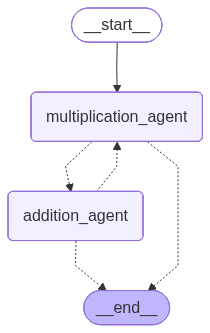

In [112]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [114]:
events=app.stream({"messages":"what is 2*3+4"},stream_mode="values")
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

what is 2*3+4
================================= Tool Message =================================

sucessfully transferred to addition agent
================================= Tool Message =================================

sucessfully transferred to multiplication agent
================================== Ai Message ==================================

The multiplication part is \(2 \times 3 = 6\).  
Adding the 4 gives \(6 + 4 = 10\).  

So the result is **10**.
